# CNN

In [1]:
import torch
from torchtext import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True,
                  pad_first=True)
LABEL = data.LabelField(dtype = torch.float)

In [2]:
from torchtext import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [3]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [4]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

In [5]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

## Build the Model

In [6]:
import torch.nn as nn

import numpy as np

class CNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)

        self.con1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=1) 
        self.con2 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=2)
        self.con3 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=3)

        self.FL = nn.Linear(3*hidden_dim, output_dim)


        
    def forward(self, text, text_lengths):
        #text = [sent len, batch size]

        embedded = self.embedding(text)
        #embedded = [sent len, batch size, emb dim]
        embedded = torch.permute(embedded, (1,2,0))
        # embedded = [batch size, emb dim, sent len]


        output1 = self.con1(embedded) #[batch size, hidden dim, out_con1]
        output1 = torch.max(output1, dim=2).values #[batch size, hidden dim]

        output2 = self.con2(embedded) #[batch size, hidden dim, out_con2]
        output2 = torch.max(output2, dim=2).values #[batch size, hidden dim]

        output3 = self.con3(embedded) #[batch size, hidden dim, out_con3]
        output3 = torch.max(output3, dim=2).values #[batch size, hidden dim]

        output = torch.cat((output1, output2, output3), 1) #[batch size, 3* hidden dim]

        return self.FL(output) #[batch size, 1]

In [7]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model_CNN = CNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
print(f'The model has {count_parameters(model_CNN):,} trainable parameters')

for p in model_CNN.parameters():
  print(type(p), p.size())

The model has 2,655,337 trainable parameters
<class 'torch.nn.parameter.Parameter'> torch.Size([25002, 100])
<class 'torch.nn.parameter.Parameter'> torch.Size([256, 100, 1])
<class 'torch.nn.parameter.Parameter'> torch.Size([256])
<class 'torch.nn.parameter.Parameter'> torch.Size([256, 100, 2])
<class 'torch.nn.parameter.Parameter'> torch.Size([256])
<class 'torch.nn.parameter.Parameter'> torch.Size([256, 100, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([256])
<class 'torch.nn.parameter.Parameter'> torch.Size([1, 768])
<class 'torch.nn.parameter.Parameter'> torch.Size([1])


## Train the Model

In [8]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [9]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [10]:
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:

        optimizer.zero_grad()

        text, text_lengths = batch.text

        predictions = model(text, text_lengths).squeeze(1)

        loss = criterion(predictions, batch.label)

        acc = binary_accuracy(predictions, batch.label)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [11]:
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for batch in iterator:
            text, text_lengths = batch.text

            predictions = model(text, text_lengths).squeeze(1)

            loss = criterion(predictions, batch.label)

            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [12]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 0.554 |  Val. Acc: 89.31%
Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 0.644 |  Val. Acc: 88.86%
Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 0.021 | Train Acc: 99.42%
	 Val. Loss: 0.621 |  Val. Acc: 88.95%
Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.001 | Train Acc: 99.99%
	 Val. Loss: 0.617 |  Val. Acc: 89.01%
Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 0.617 |  Val. Acc: 89.08%
Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 0.616 |  Val. Acc: 89.15%
Epoch: 07 | Epoch Time: 0m 7s
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 0.615 |  Val. Acc: 89.11%
Epoch: 08 | Epoch Time: 0m 7s
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 0.615 |  Val. Acc: 89.15%
Epoch: 09 | Epoch Time: 0m 7s
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 0.614 |  Val. Acc: 89.13%
Epoch: 10 | Epoch Tim

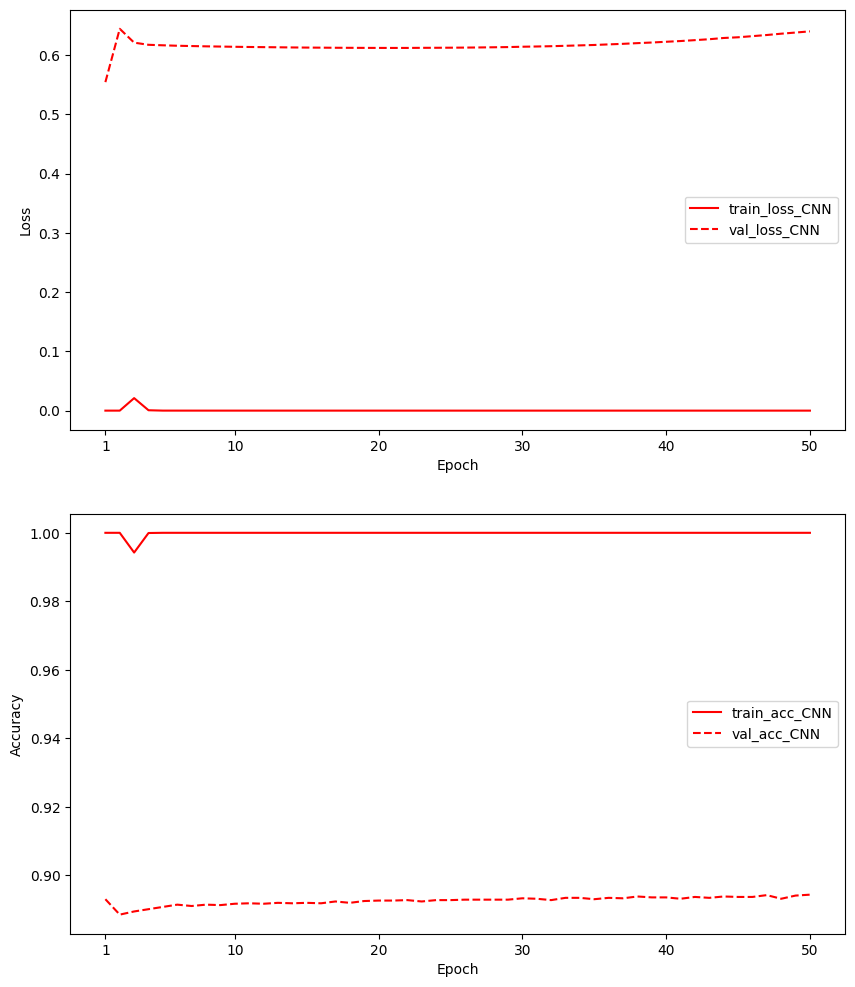

In [14]:
import matplotlib.pyplot as plt

optimizer_Adam = optim.Adam(model_CNN.parameters(), lr=1e-3)
model_CNN = model_CNN.to(device)

N_EPOCHS = 50

train_loss_CNN = []
train_acc_CNN = []
val_loss_CNN = []
val_acc_CNN = []
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model_CNN, train_iterator, optimizer_Adam, criterion)
    valid_loss, valid_acc = evaluate(model_CNN, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_CNN.state_dict(), 'model_CNN.pt')
    
    train_loss_CNN.append(train_loss)
    train_acc_CNN.append(train_acc)
    val_loss_CNN.append(valid_loss)
    val_acc_CNN.append(valid_acc)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,12))
ax1.plot(train_loss_CNN, 'r-', label='train_loss_CNN')
ax1.plot(val_loss_CNN, 'r--', label='val_loss_CNN')
ax2.plot(train_acc_CNN, 'r-', label='train_acc_CNN')
ax2.plot(val_acc_CNN, 'r--', label='val_acc_CNN')

ax1.set_xticks([0,9,19,29,39,49], labels=[1,10,20,30,40,50])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.set_xticks([0,9,19,29,39,49], labels=[1,10,20,30,40,50])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()


# 
model_CNN.load_state_dict(torch.load('model_CNN.pt'))

test_loss_CNN, test_acc_CNN = evaluate(model_CNN, test_iterator, criterion)

print(f'Test Loss: {test_loss_CNN:.3f} | Test Acc: {test_acc_CNN*100:.2f}%')